In [94]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.stats import gaussian_kde

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import random

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000

In [95]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [96]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
            for stat in ['count', 'count_norm']:
                column_names.append('%s_%s_%s' % (df_name, var, stat))
    categorical.columns = column_names
    return categorical

def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [97]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

# bureauを最近のものだけに

In [99]:
description[description['Table'] == 'bureau.csv']

,Table,Row,Description,日本語訳,Special
125,bureau.csv,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau","私たちのサンプル中のローンのIDは - 私たちのサンプル中の1つのローンは信用調査機関で0,1,2以上の関連以前のクレジットを持つことができます",hashed
126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),私たちのローンに関連する以前の信用調査のクレジット（各ローン申請のためのユニークな符号化）の録画ID,hashed
127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,クレジットビューロー（CB）の状況は、クレジットを報告しました,NaN
128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,クレジットビューローの信用の録画通貨,recoded
129,bureau.csv,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,クライアントは、クレジットビューローの信用のために何日現在の適用前に適用されませんでした,time only relative to the application
130,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,私たちのサンプルの関連ローンの申請時のCBの信用上の延滞日数,NaN
131,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,ホームクレジットでのアプリケーションの時点で（日中）CBクレジットの残りの期間,time only relative to the application
132,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),CBのクレジットは（のみ閉じ信用のため）ホームクレジットでのアプリケーションの時点で終了してからの日数,time only relative to the application
133,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),これまでの信用調査のクレジットで延滞達する最大（このサンプルでは、​​ローンの申請日において）,NaN
134,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,クレジットビューロークレジットはどのように多くの時間延長しました,NaN


In [100]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2432.0,-2492.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


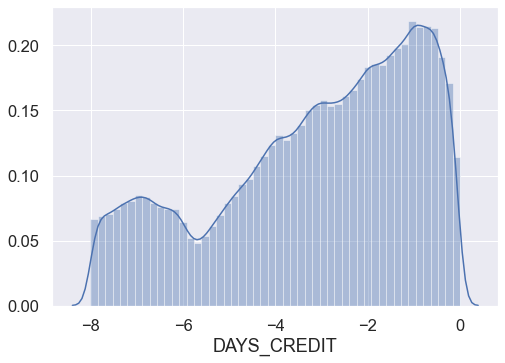

In [101]:
sns.distplot(bureau['DAYS_CREDIT'] / 365)

In [102]:
bureau['CREDIT_ACTIVE'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

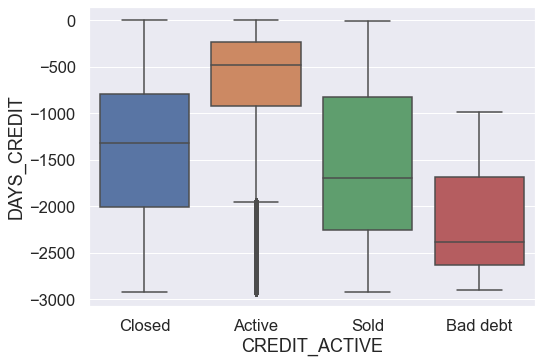

In [103]:
sns.boxplot(x='CREDIT_ACTIVE', y='DAYS_CREDIT', data=bureau)

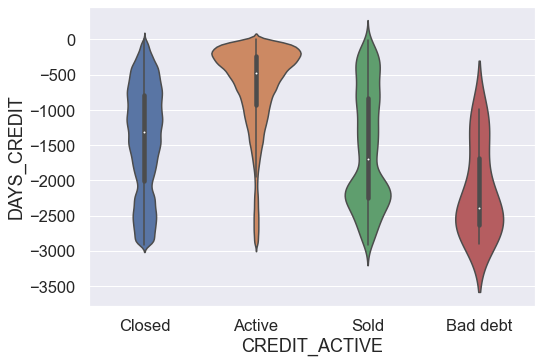

In [104]:
sns.violinplot(x='CREDIT_ACTIVE', y='DAYS_CREDIT', data=bureau)

In [105]:
print(len(application_train['SK_ID_CURR'].unique()) - len(bureau['SK_ID_CURR'].unique()))
print(len(application_train['SK_ID_CURR'].unique()))
print(len(bureau['SK_ID_CURR'].unique()))

# そもそもbureauにデータがあるかが特徴量になる説
# 包含関係大丈夫か、setを使う

1700
307511
305811


In [106]:
not_in_bureau_ID = set(application_train['SK_ID_CURR'].unique().tolist()) - set(bureau['SK_ID_CURR'].unique().tolist())
application_train['notin_bureau'] = application_train["SK_ID_CURR"].apply(lambda x: 1 if x in not_in_bureau_ID else 0)
application_test['notin_bureau'] = application_test["SK_ID_CURR"].apply(lambda x: 1 if x in not_in_bureau_ID else 0)

In [107]:
pivot = pd.pivot_table(application_train, index='notin_bureau', columns='TARGET', values='SK_ID_CURR', aggfunc='count')
print('notin_bureau = 0 : {} % が債務不履行'.format((pivot.iloc[0,0] + pivot.iloc[0,1]) / pivot.iloc[0,1]))
print('notin_bureau = 1 : {} % が債務不履行'.format((pivot.iloc[1,0] + pivot.iloc[1,1]) / pivot.iloc[1,1]))
pivot

notin_bureau = 0 : 12.936518067556952 % が債務不履行
notin_bureau = 1 : 9.876598608929774 % が債務不履行


TARGET,0,1
notin_bureau,,
0,243123,20368
1,39563,4457


# bureauを削ってみる

削ったのを全部joinする感じ

In [108]:
bureau = bureau[bureau['DAYS_CREDIT'] / 365 > -5]

In [109]:
print(len(application_train['SK_ID_CURR'].unique()) - len(bureau['SK_ID_CURR'].unique()))
print(len(application_train['SK_ID_CURR'].unique()))
print(len(bureau['SK_ID_CURR'].unique()))

13810
307511
293701


In [110]:
not_in_new_bureau_ID = set(application_train['SK_ID_CURR'].unique().tolist()) - set(bureau['SK_ID_CURR'].unique().tolist())
application_train['notin_new_bureau'] = application_train["SK_ID_CURR"].apply(lambda x: 1 if x in not_in_new_bureau_ID else 0)
application_test['notin_new_bureau'] = application_test["SK_ID_CURR"].apply(lambda x: 1 if x in not_in_new_bureau_ID else 0)

In [111]:
pivot = pd.pivot_table(application_train, index='notin_new_bureau', columns='TARGET', values='SK_ID_CURR', aggfunc='count')
print('notin_new_bureau = 0 : {} % が債務不履行'.format((pivot.iloc[0,0] + pivot.iloc[0,1]) / pivot.iloc[0,1]))
print('notin_new_bureau = 1 : {} % が債務不履行'.format((pivot.iloc[1,0] + pivot.iloc[1,1]) / pivot.iloc[1,1]))
pivot
# 職業ごと？年齢ごと？何かと掛け合わせたほうがいいかも

notin_new_bureau = 0 : 12.804873106732181 % が債務不履行
notin_new_bureau = 1 : 10.765145554681354 % が債務不履行


TARGET,0,1
notin_new_bureau,,
0,233040,19741
1,49646,5084


# 削った状態でデータを作り直す

In [112]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [113]:
application_train = application_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
application_train = application_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
application_train = application_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [114]:
missing_train = missing_values_table(application_train)
missing_train.head(100)

Your selected dataframe has 335 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,231581,75.3
bureau_AMT_ANNUITY_max,231581,75.3
bureau_AMT_ANNUITY_mean,231581,75.3
client_bureau_balance_STATUS_4_count_min,218411,71.0
client_bureau_balance_STATUS_3_count_norm_mean,218411,71.0
client_bureau_balance_MONTHS_BALANCE_count_min,218411,71.0
client_bureau_balance_STATUS_4_count_max,218411,71.0
client_bureau_balance_STATUS_4_count_mean,218411,71.0
client_bureau_balance_STATUS_3_count_norm_min,218411,71.0
client_bureau_balance_STATUS_3_count_norm_max,218411,71.0


In [115]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

In [116]:
test = application_test
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [117]:
train_labels = application_train['TARGET']
application_train, test = application_train.align(test, join = 'inner', axis = 1)

application_train['TARGET'] = train_labels

In [118]:
missing_test = missing_values_table(test)

Your selected dataframe has 334 columns.
There are 275 columns that have missing values.


In [119]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [120]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [121]:
application_train = application_train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [122]:
corrs = application_train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)

pd.DataFrame(corrs['TARGET'].head(10))
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_STATUS_C_count_norm_mean,-0.047051
client_bureau_balance_STATUS_C_count_max,-0.048189
client_bureau_balance_MONTHS_BALANCE_count_min,-0.056394
client_bureau_balance_STATUS_C_count_mean,-0.056575
client_bureau_balance_MONTHS_BALANCE_count_max,-0.062064
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.064598
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.079953
EXT_SOURCE_1,-0.155318
EXT_SOURCE_2,-0.160471
EXT_SOURCE_3,-0.178918


In [123]:
threshold = 0.8

above_threshold_vars = {}

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  148


In [124]:
train_corrs_removed = application_train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 187)
Testing Corrs Removed Shape:  (48744, 186)


In [125]:
train_corrs_removed.to_pickle('train_bureau_corrs_removed.pkl')
test_corrs_removed.to_pickle('test_bureau_corrs_removed.pkl')

# モデリング

In [126]:
train = pd.read_pickle('../home credit/train_bureau_corrs_removed.pkl')
test = pd.read_pickle('../home credit/test_bureau_corrs_removed.pkl')
train.shape,test.shape

((307511, 187), (48744, 186))

In [127]:
def num_cat(df):
    num_f = df.dtypes[df.dtypes != 'object'].index
    cat_f = df.dtypes[df.dtypes == 'object'].index
    return num_f, cat_f

In [128]:
num_f, cat_f = num_cat(train)

In [129]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train[cat_f] = train[cat_f].fillna('nan')
test[cat_f] = test[cat_f].fillna('nan')
for cat in cat_f:
    train[cat] = le.fit_transform(train[cat])
    test[cat] = le.fit_transform(test[cat])

In [130]:
train_y = train['TARGET']
train_X = train.drop(['TARGET'], axis=1)

In [131]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_indexes = []
    train_score = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6785)
    
    feature_importance_df = pd.DataFrame()
    col = list(train_x.columns)
    i = 1
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        tr_x, tr_y = sampler.fit_resample(tr_x, tr_y)
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=1000, 
                  early_stopping_rounds=20)
        
        
        tr_pred = model.predict_proba(tr_x)[:, 1]
        pred = model.predict_proba(va_x)[:, 1]
        preds.append(pred)
        pred_test = model.predict_proba(test_x)[:, 1]
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        i += 1
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred)), 
              '  score Valid : {:.6f}' .format(roc_auc_score(va_y, pred)))
        train_score.append(roc_auc_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('*'*40)
    print('train Score : {:.6f}' .format(np.mean(train_score)))
    print('valid Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    return pred_train, preds_test, model, feat_df

In [132]:
import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import gc

import matplotlib.pyplot as plt

In [133]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_X, train_y, test)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[95]	training's auc: 0.824484	training's binary_logloss: 0.524432	valid_1's auc: 0.755987	valid_1's binary_logloss: 0.584226
  score Train : 0.824484   score Valid : 0.755987
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[107]	training's auc: 0.831464	training's binary_logloss: 0.5158	valid_1's auc: 0.762867	valid_1's binary_logloss: 0.586622
  score Train : 0.831464   score Valid : 0.762867
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	training's auc: 0.832479	training's binary_logloss: 0.51597	valid_1's auc: 0.760289	valid_1's binary_logloss: 0.581765
  score Train : 0.832479   score Valid : 0.760289
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	training's auc: 0.832369	training's binary_logloss: 0.515943	valid_1's auc: 0.758999	v

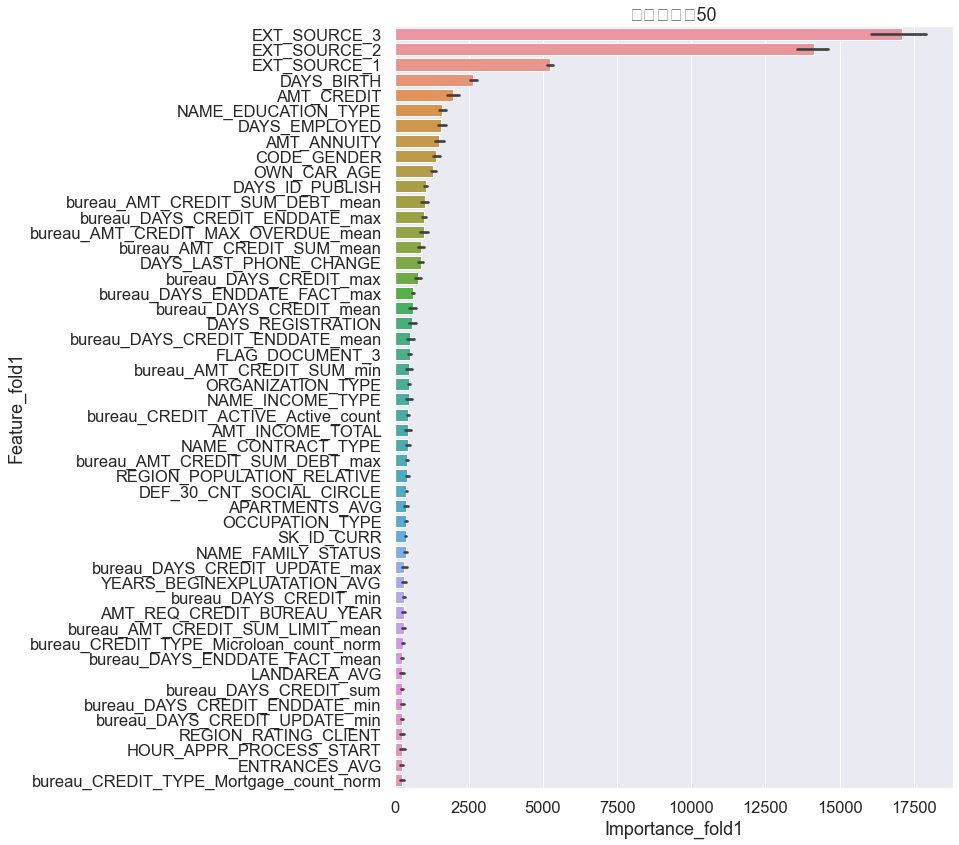

In [134]:
def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    # e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    
    feat = pd.concat([a, b, c, d]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)[["Feature_fold1",'Importance_fold1']]
    plt.figure(figsize=(10,14))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices.iloc[:50, 0])
    return indices
indices = feature_importance_plot(feat_df)

In [135]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)

# 以前作った特徴量追加

In [136]:
train = pd.read_pickle('../home credit/train_bureau_corrs_removed.pkl')
test = pd.read_pickle('../home credit/test_bureau_corrs_removed.pkl')
df = pd.concat([train, test], sort=False).reset_index(drop=True)

In [137]:
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df = df.drop('SK_ID_CURR', axis=1)

In [138]:
df

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,notin_bureau,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_

In [139]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].reset_index(drop=True)
train_y = train_df['TARGET']
train_df.drop(['TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET'], axis=1, inplace=True)

num_f, cat_f = num_cat(train_df)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df[cat_f] = train_df[cat_f].fillna('nan')
test_df[cat_f] = test_df[cat_f].fillna('nan')
for cat in cat_f:
    train_df[cat] = le.fit_transform(train_df[cat])
    test_df[cat] = le.fit_transform(test_df[cat])

In [140]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	training's auc: 0.841516	training's binary_logloss: 0.504759	valid_1's auc: 0.764749	valid_1's binary_logloss: 0.577929
  score Train : 0.841516   score Valid : 0.764749
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	training's auc: 0.849229	training's binary_logloss: 0.495562	valid_1's auc: 0.771872	valid_1's binary_logloss: 0.577769
  score Train : 0.849229   score Valid : 0.771872
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	training's auc: 0.857459	training's binary_logloss: 0.487561	valid_1's auc: 0.766293	valid_1's binary_logloss: 0.575603
  score Train : 0.857459   score Valid : 0.766293
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	training's auc: 0.840329	training's binary_logloss: 0.505568	valid_1's auc: 0.7660

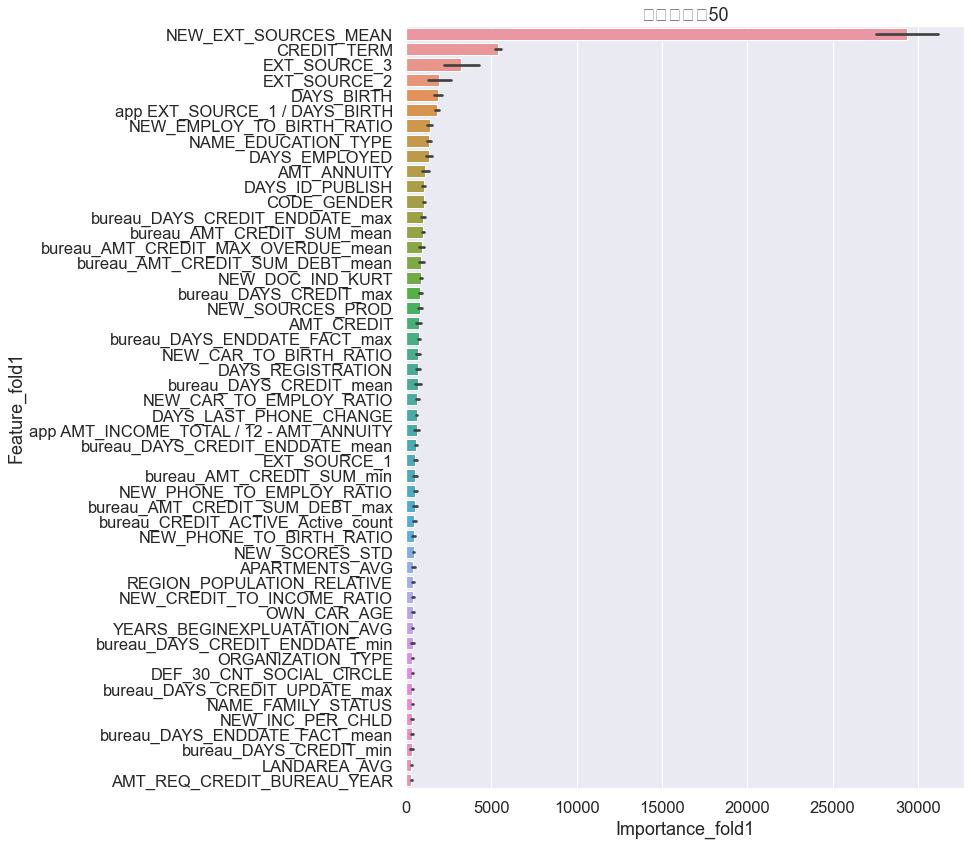

In [141]:
indices = feature_importance_plot(feat_df)

In [142]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)

# 特徴量をimportanceをもとに削ってみる

In [143]:
df_try = df[np.append(indices.iloc[:100, 0].values, 'TARGET')]

In [144]:
train_df = df_try[df_try['TARGET'].notnull()]
test_df = df_try[df_try['TARGET'].isnull()].reset_index(drop=True)
train_y = train_df['TARGET']
train_df.drop(['TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET'], axis=1, inplace=True)

num_f, cat_f = num_cat(train_df)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df[cat_f] = train_df[cat_f].fillna('nan')
test_df[cat_f] = test_df[cat_f].fillna('nan')
for cat in cat_f:
    train_df[cat] = le.fit_transform(train_df[cat])
    test_df[cat] = le.fit_transform(test_df[cat])
    
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	training's auc: 0.842882	training's binary_logloss: 0.503024	valid_1's auc: 0.764559	valid_1's binary_logloss: 0.577566
  score Train : 0.842882   score Valid : 0.764559
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[133]	training's auc: 0.851726	training's binary_logloss: 0.49244	valid_1's auc: 0.770665	valid_1's binary_logloss: 0.578151
  score Train : 0.851726   score Valid : 0.770665
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	training's auc: 0.85245	training's binary_logloss: 0.492958	valid_1's auc: 0.766852	valid_1's binary_logloss: 0.575249
  score Train : 0.852450   score Valid : 0.766852
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	training's auc: 0.833613	training's binary_logloss: 0.512745	valid_1's auc: 0.76476	v

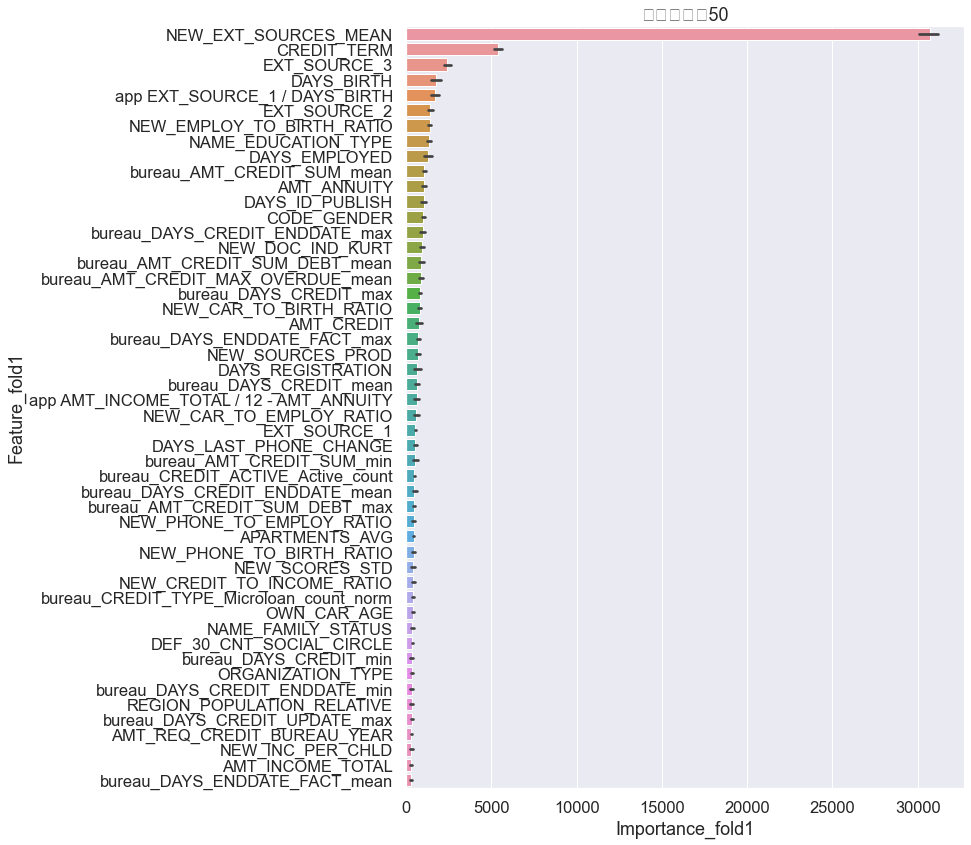

In [145]:
indices = feature_importance_plot(feat_df)

In [146]:
df_try = df[np.append(indices.iloc[1:, 0].values, 'TARGET')]

train_df = df_try[df_try['TARGET'].notnull()]
test_df = df_try[df_try['TARGET'].isnull()].reset_index(drop=True)
train_y = train_df['TARGET']
train_df.drop(['TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET'], axis=1, inplace=True)

num_f, cat_f = num_cat(train_df)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df[cat_f] = train_df[cat_f].fillna('nan')
test_df[cat_f] = test_df[cat_f].fillna('nan')
for cat in cat_f:
    train_df[cat] = le.fit_transform(train_df[cat])
    test_df[cat] = le.fit_transform(test_df[cat])
    
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[120]	training's auc: 0.843384	training's binary_logloss: 0.502642	valid_1's auc: 0.765223	valid_1's binary_logloss: 0.577226
  score Train : 0.843384   score Valid : 0.765223
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[136]	training's auc: 0.852386	training's binary_logloss: 0.492133	valid_1's auc: 0.773472	valid_1's binary_logloss: 0.577317
  score Train : 0.852386   score Valid : 0.773472
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[111]	training's auc: 0.83964	training's binary_logloss: 0.507086	valid_1's auc: 0.767155	valid_1's binary_logloss: 0.574682
  score Train : 0.839640   score Valid : 0.767155
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	training's auc: 0.841166	training's binary_logloss: 0.504688	valid_1's auc: 0.76673

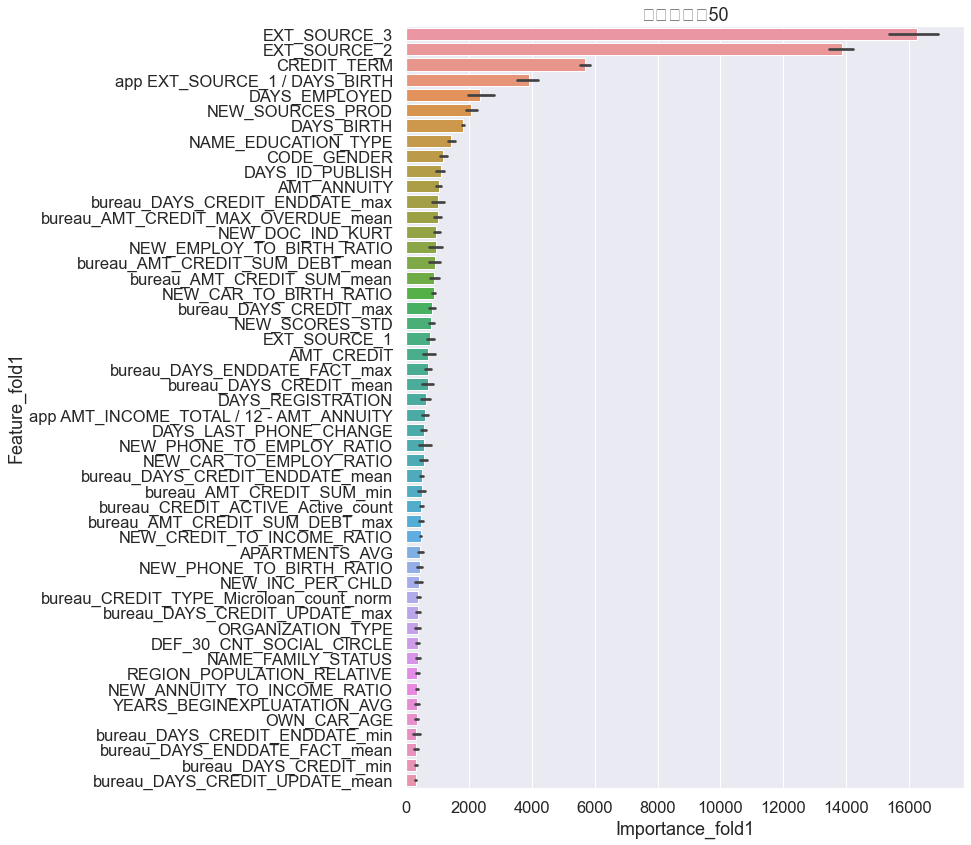

In [147]:
indices = feature_importance_plot(feat_df)

In [148]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)